# Custom ResNets Trained On CIFAR100

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.2 MB/s eta 0:00:0000:01


In [2]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Functions

In [4]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
        transforms.RandomErasing()
    ])

    test_val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    ])

    return train_transform, test_val_transform

In [5]:
def get_loaders(batch_size=128):

    train_transform, val_transform = get_transforms()

    train_dataset = CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    val_dataset = CIFAR100(root="./data", train=False, transform=val_transform, download=True)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True, 
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True, 
        persistent_workers=True
    )

    return train_loader, val_loader


In [6]:
def train_setup(
        model, lr=0.1, 
        momentum=0.9, 
        weight_decay=1e-4, 
        milestones=[100, 150], gamma=0.1
    ):
    
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(
        model.parameters(), 
        lr=lr, 
        momentum=momentum, 
        weight_decay=weight_decay
    )

    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer=optimizer,
        milestones=milestones,
        gamma=gamma
    )

    return criterion, optimizer, scheduler

In [7]:
def get_metrics(device, num_classes=100):
    
    metrics = torchmetrics.MetricCollection({
        'acc_top1': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=1),
        'acc_top5': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=5)
    }).to(device)

    return metrics

In [8]:
def train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        criterion, 
        scheduler, 
        metrics, 
        device
    ):
    
    model.train()
    loss_per_epoch = 0.0

    metrics.reset()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        loss_per_epoch += loss.item()
        metrics.update(output, labels)
    
    if scheduler:
        scheduler.step()
    
    loss_per_epoch /= len(train_loader)
    return metrics, loss_per_epoch

In [9]:
def validate(model, val_loader, criterion, metrics, device):
    model.eval()
    loss_per_epoch = 0.0

    metrics.reset()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            loss_per_epoch += loss.item()

            metrics.update(output, labels)
        
    loss_per_epoch /= len(val_loader)
    
    return metrics, loss_per_epoch

In [10]:
def plot_learning_curves(train_hist, val_hist):
    # Extract data
    loss_train = train_hist['train_loss']
    loss_val = val_hist['val_loss']
    
    acc1_train = train_hist['train_acc_top_1']
    acc1_val = val_hist['val_acc_top_1']
    
    acc5_train = train_hist['train_acc_top_5']
    acc5_val = val_hist['val_acc_top_5']

    epochs = range(1, len(loss_train) + 1)
    
    # Create a 1x2 grid (Loss on left, Accuracy on right)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Loss
    ax1.plot(epochs, loss_train, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, loss_val, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot Top-1 (Solid Lines)
    ax2.plot(epochs, acc1_train, 'b-', label='Train Top-1', linewidth=2)
    ax2.plot(epochs, acc1_val, 'r-', label='Val Top-1', linewidth=2)
    
    # Plot Top-5 (Dashed Lines)
    ax2.plot(epochs, acc5_train, 'b--', label='Train Top-5', alpha=0.7)
    ax2.plot(epochs, acc5_val, 'r--', label='Val Top-5', alpha=0.7)
    
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Top-1 & Top-5 Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10, loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cifar100_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def plot_saliency_map(model, dataloader, device):
    # Set model to evaluation mode
    model.eval()

    # Select a batch from dataloader
    images, labels = next(iter(dataloader))
    
    # Move the batch to GPU
    images, labels = images.to(device), labels.to(device)

    # Select the first image and label from the batch
    image, label = images[0], labels[0]

    # Add batch dimension to the image
    image = image.unsqueeze(0)

    # Enable gradient tracking on the image
    image.requires_grad_(True)

    # Pass the image to the model (Forward Pass)
    output = model(image)

    # Find the predicted class
    pred_class = torch.argmax(output, dim=1).item()

    # Find raw scalar value of the predicted class
    target_score = output[0, pred_class] # Shape: [1 -> Image, 100 -> Num Classes]

    # Set model's gradient to zero
    model.zero_grad()

    # Set image's pixels' gradients to zero
    if image.grad is not None:
        image.grad.zero_()
    
    # Perform Backward Pass on the target_score
    target_score.backward()

    # --- Extract Saliency Map ---
    # Select image gradients and detach them
    saliency = image.grad.detach()

    # Remove batch dimension that was added earlier
    saliency = saliency.squeeze()

    # Take absolute value of every gradient
    saliency = saliency.abs()

    # Collapse RGB channels → (32, 32)
    saliency, _ = torch.max(saliency, dim=0)

    # # ---  Normalize Saliency ---
    # # Subtract saliency by the minimum of the gradients
    # saliency -= saliency.min()

    # # Divide saliency by the maximum of the gradients
    # saliency /= saliency.max() + 1e-8

    saliency = saliency.cpu()

    # ---- Unnormalize image ----
    # Prepare original image for plotting
    mean = torch.tensor([0.5071, 0.4867, 0.4408]).to(device)
    std = torch.tensor([0.2675, 0.2565, 0.2761]).to(device)

    original_image = images[0] * std[:, None, None] + mean[:, None, None]
    original_image = original_image.clamp(0, 1)
    original_image = images[0].cpu().permute(1, 2, 0)

    # Move saliency to CPU

    # Plot results
    plt.figure(figsize=(10, 4))
    
    # Plot Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original (Class: {label.item()})")
    plt.axis('off')

    # Plot Saliency
    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='jet') # 'jet' or 'hot' are best for heatmaps
    plt.title(f"Saliency Map (Pred: {pred_class})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
def plot_grad_cam(model, dataloader, last_layer, device):
    # Set the model to evaluation mode
    model.eval()

    # Select a batch from the dataloader
    images, labels = next(iter(dataloader))

    # Move the batch to the GPU
    images, labels = images.to(device), labels.to(device)

    # Select first image and label from the batch
    image, label = images[0], labels[0]

    # Add batch dimension to the image
    image = image.unsqueeze(0)

    # Select last nn.Conv2d layer of the model
    target_layer = last_layer

    # Initialize empty feature_maps and gradients
    feature_maps = None
    gradients = None

    # Define forward hook
    def forward_hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Define backward hook
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]
    
    # Set the hooks on the target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(image)

    # Find the predicted class
    pred_class = torch.argmax(output, dim=1).item()

    # Find the scalar value of the predicted class
    target_score = output[0, pred_class]

    # Set model gradients to zero
    model.zero_grad()

    # Perform backward pass on target_score
    target_score.backward()

    # --- Generate CAM ---
    # Find mean of gradients along height and width
    weights = gradients.mean(dim=(2,3), keepdim=True)

    # Find weighted sum of the feature maps
    cam = (weights * feature_maps).sum(dim=1, keepdim=True)

    # Apply ReLU
    cam = F.relu(cam)

    # Upsample the CAM
    cam = F.interpolate(cam, size=(32, 32), mode="bilinear", align_corners=False)

    # Remove the batch dimension that was added earlier
    cam = cam.squeeze()

    # --- Normalize CAM ---
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    # Detach from graph, move to CPU, convert to numpy
    cam = cam.detach().cpu().numpy()

    # Prepare origina image for plotting
    original_image = images[0].cpu().permute(1, 2, 0)

    # Plot the original image and GradCAM
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {label.item()})")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM (Class: {pred_class})")
    plt.imshow(original_image, cmap="gray")
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Remove the hooks, otherwise it will cause memory leaks in future training
    forward_handle.remove()
    backward_handle.remove()

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            self.counter += 1

            if self.counter >= self.patience:
                self.early_stop = True

# Model #1: ResNet-20

In [14]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(ResidualLayer, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample

    def _initial_forward(self, x):
        return self.block(x)
    
    def forward(self, x):
        identity = x

        output = self._initial_forward(x)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        output += identity

        output = F.relu(output)

        return output

In [17]:
class ResNet20(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet20, self).__init__()

        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        num_layers_per_block = 3

        # Residual Blocks
        self.res_block_1 = self._make_residual_block(16, 16, num_layers_per_block, stride=1)
        self.res_block_2 = self._make_residual_block(16, 32, num_layers_per_block, stride=2)
        self.res_block_3 = self._make_residual_block(32, 64, num_layers_per_block, stride=2)

        # Global Average Pooling (GAP)
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layer = nn.Linear(64, num_classes)

    def _make_residual_block(self, in_channels, out_channels, num_layers, stride=1):

        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(ResidualLayer(in_channels, out_channels, stride, downsample=downsample))

        for _ in range(1, num_layers):
            layers.append(ResidualLayer(out_channels, out_channels, stride=1, downsample=None))
        
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
        
    def forward(self, x):

        x = self.initial_conv(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_3(x)

        x = self.gap(x)

        x = torch.flatten(x, 1)

        x = self.fc_layer(x)

        return x

## Training & Evaluation Session

### With Early Stopping

In [18]:
resnet20 = ResNet20().to(device)
resnet20._initialize_weights()
early_stopping = EarlyStopping(patience=10, min_delta=1e-3)

train_loader, val_loader = get_loaders()
criterion, optimizer, scheduler = train_setup(resnet20)
train_metrics = get_metrics(device)
val_metrics = get_metrics(device)

EPOCHS = 200

100%|██████████| 169M/169M [00:05<00:00, 30.6MB/s] 


In [19]:
train_history = {"train_loss":[], "train_acc_top_1":[], "train_acc_top_5":[]}
val_history = {"val_loss":[], "val_acc_top_1":[], "val_acc_top_5":[]}

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    _, train_loss = train_one_epoch(resnet20, train_loader, optimizer, criterion, scheduler, train_metrics, device)
    _, val_loss = validate(resnet20, val_loader, criterion, val_metrics, device)

    train_results = train_metrics.compute()
    val_results = val_metrics.compute()

    train_acc_1 = train_results['acc_top1'].item()
    train_acc_5 = train_results['acc_top5'].item()
    
    val_acc_1 = val_results['acc_top1'].item()
    val_acc_5 = val_results['acc_top5'].item()

    train_history['train_loss'].append(train_loss)
    train_history['train_acc_top_1'].append(train_acc_1)
    train_history['train_acc_top_5'].append(train_acc_5)

    val_history['val_loss'].append(val_loss)
    val_history['val_acc_top_1'].append(val_acc_1)
    val_history['val_acc_top_5'].append(val_acc_5)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc_1:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc_1:.2%}")
    
    early_stopping(val_loss, resnet20)

    if early_stopping.early_stop:
        print(f"Early Stopping triggered at epoch {epoch+1}")
        break

resnet20.load_state_dict(torch.load("best_model.pth"))

end_time = time.time()

print("\nTraining Complete!")
print(f"Total Training Time: {end_time - start_time:.2f}s")

Starting training...
Epoch 1/200 | Train Loss: 4.0865 | Train Acc: 6.38% | Val Loss: 3.7883 | Val Acc: 9.58%
Epoch 2/200 | Train Loss: 3.6485 | Train Acc: 12.44% | Val Loss: 3.5354 | Val Acc: 15.40%
Epoch 3/200 | Train Loss: 3.3340 | Train Acc: 18.37% | Val Loss: 3.2401 | Val Acc: 21.68%
Epoch 4/200 | Train Loss: 3.0494 | Train Acc: 23.53% | Val Loss: 2.9159 | Val Acc: 26.61%
Epoch 5/200 | Train Loss: 2.8427 | Train Acc: 27.41% | Val Loss: 2.9827 | Val Acc: 27.45%
Epoch 6/200 | Train Loss: 2.6805 | Train Acc: 30.85% | Val Loss: 2.6701 | Val Acc: 31.26%
Epoch 7/200 | Train Loss: 2.5445 | Train Acc: 33.67% | Val Loss: 2.7794 | Val Acc: 32.93%
Epoch 8/200 | Train Loss: 2.4312 | Train Acc: 36.09% | Val Loss: 2.6836 | Val Acc: 35.45%
Epoch 9/200 | Train Loss: 2.3390 | Train Acc: 37.94% | Val Loss: 2.6372 | Val Acc: 35.61%
Epoch 10/200 | Train Loss: 2.2540 | Train Acc: 39.85% | Val Loss: 2.1076 | Val Acc: 44.05%
Epoch 11/200 | Train Loss: 2.1834 | Train Acc: 41.47% | Val Loss: 2.2827 | Val A

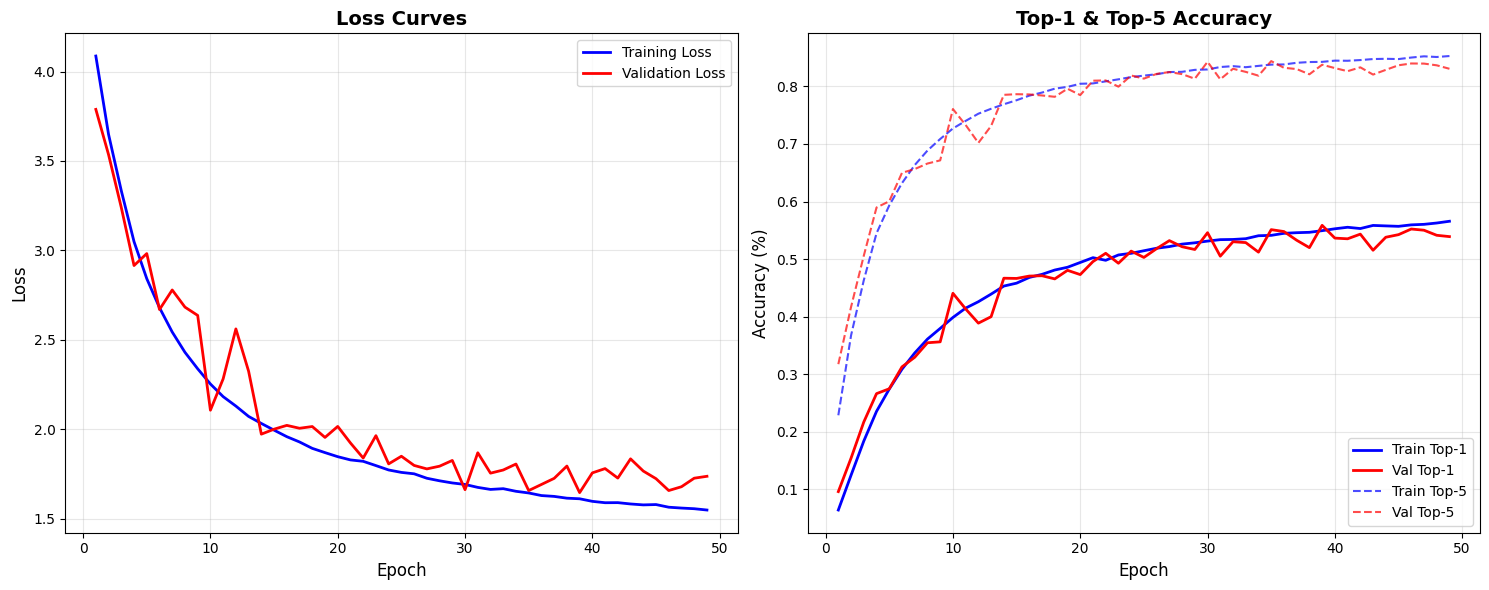

In [20]:
plot_learning_curves(train_history, val_history)

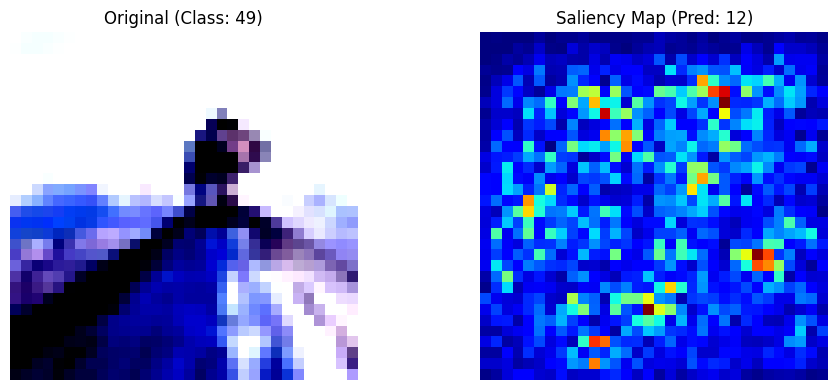

In [21]:
plot_saliency_map(resnet20, val_loader, device)

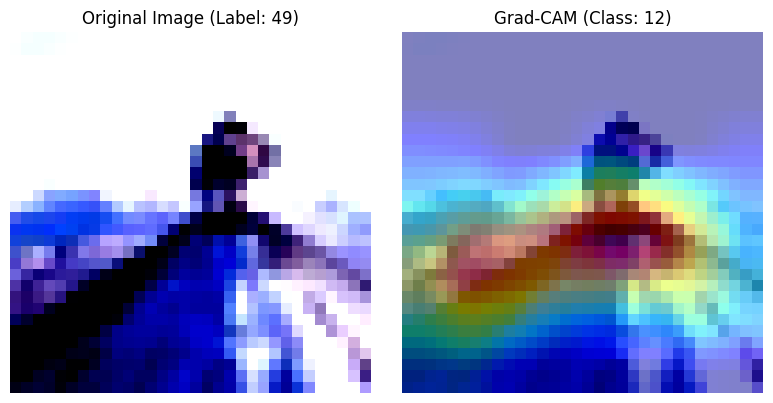

In [22]:
plot_grad_cam(resnet20, val_loader, resnet20.res_block_3[2].block[3], device)

### Without Early Stopping

In [23]:
resnet20_2 = ResNet20().to(device)
resnet20_2._initialize_weights()

train_loader, val_loader = get_loaders()
criterion, optimizer, scheduler = train_setup(resnet20_2)
train_metrics = get_metrics(device)
val_metrics = get_metrics(device)

EPOCHS = 200

In [24]:
train_history = {"train_loss":[], "train_acc_top_1":[], "train_acc_top_5":[]}
val_history = {"val_loss":[], "val_acc_top_1":[], "val_acc_top_5":[]}

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    _, train_loss = train_one_epoch(resnet20_2, train_loader, optimizer, criterion, scheduler, train_metrics, device)
    _, val_loss = validate(resnet20_2, val_loader, criterion, val_metrics, device)

    train_results = train_metrics.compute()
    val_results = val_metrics.compute()

    train_acc_1 = train_results['acc_top1'].item()
    train_acc_5 = train_results['acc_top5'].item()
    
    val_acc_1 = val_results['acc_top1'].item()
    val_acc_5 = val_results['acc_top5'].item()

    train_history['train_loss'].append(train_loss)
    train_history['train_acc_top_1'].append(train_acc_1)
    train_history['train_acc_top_5'].append(train_acc_5)

    val_history['val_loss'].append(val_loss)
    val_history['val_acc_top_1'].append(val_acc_1)
    val_history['val_acc_top_5'].append(val_acc_5)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc_1:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc_1:.2%}")

end_time = time.time()

print("\nTraining Complete!")
print(f"Total Training Time: {end_time - start_time:.2f}s")

Starting training...
Epoch 1/200 | Train Loss: 4.0925 | Train Acc: 6.45% | Val Loss: 3.8066 | Val Acc: 9.97%
Epoch 2/200 | Train Loss: 3.6271 | Train Acc: 12.94% | Val Loss: 3.5200 | Val Acc: 15.87%
Epoch 3/200 | Train Loss: 3.3322 | Train Acc: 18.48% | Val Loss: 3.4137 | Val Acc: 19.54%
Epoch 4/200 | Train Loss: 3.0705 | Train Acc: 23.29% | Val Loss: 2.8593 | Val Acc: 27.27%
Epoch 5/200 | Train Loss: 2.8631 | Train Acc: 27.36% | Val Loss: 2.9854 | Val Acc: 27.64%
Epoch 6/200 | Train Loss: 2.6823 | Train Acc: 31.03% | Val Loss: 2.6241 | Val Acc: 33.47%
Epoch 7/200 | Train Loss: 2.5450 | Train Acc: 33.75% | Val Loss: 2.5125 | Val Acc: 35.14%
Epoch 8/200 | Train Loss: 2.4266 | Train Acc: 36.24% | Val Loss: 2.3122 | Val Acc: 38.99%
Epoch 9/200 | Train Loss: 2.3351 | Train Acc: 38.25% | Val Loss: 2.5011 | Val Acc: 38.03%
Epoch 10/200 | Train Loss: 2.2437 | Train Acc: 40.40% | Val Loss: 2.2788 | Val Acc: 40.55%
Epoch 11/200 | Train Loss: 2.1719 | Train Acc: 41.79% | Val Loss: 2.2657 | Val A

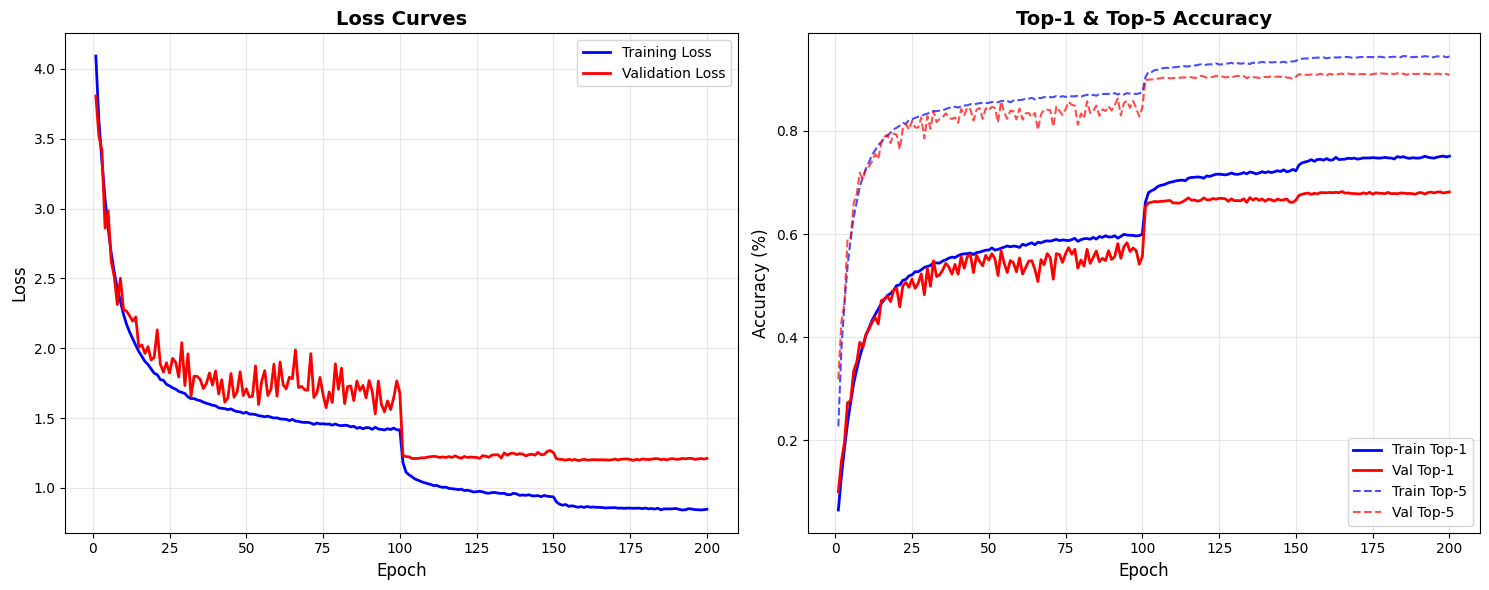

In [25]:
plot_learning_curves(train_history, val_history)

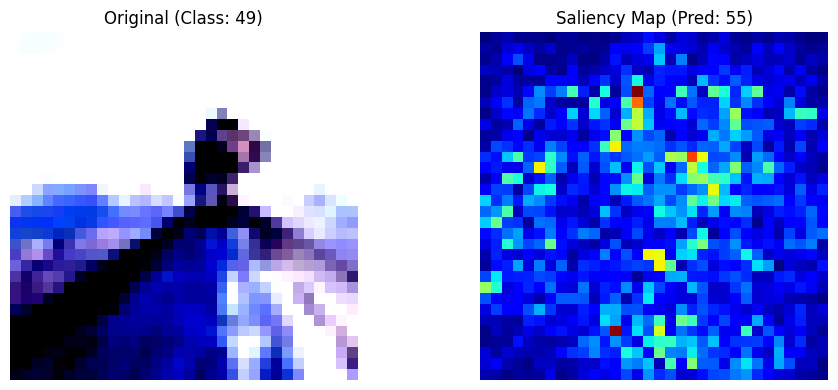

In [26]:
plot_saliency_map(resnet20_2, val_loader, device)

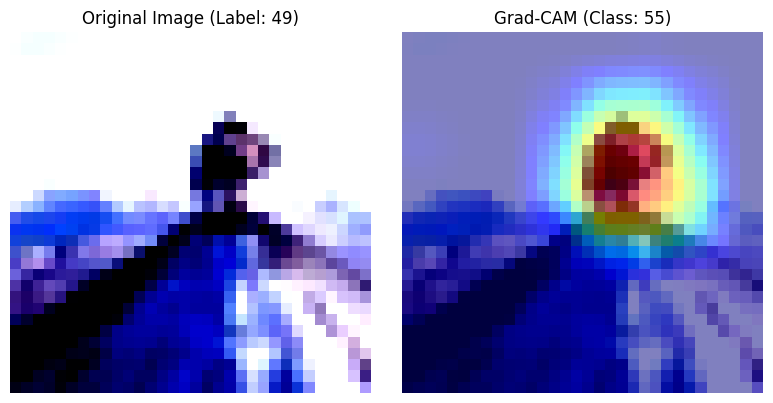

In [29]:
plot_grad_cam(resnet20_2, val_loader, resnet20_2.res_block_3[2].block[3], device)

ResNet20 performs better on the CIFAR100 dataset when it's not restricted by Early Stopping. 
It can be seen in the learning curves that lower learning rates perform better on the task.

# Model #2: ResNet-50

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, expansion=4):
        super(BottleneckBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),         
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),                    
            nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * expansion)
        )

        self.downsample = downsample

    def _initial_forward(self, x):
        return self.block(x)

    def forward(self, x):
        identity = x

        output = self._initial_forward(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        output += identity

        output = F.relu(output)

        return output

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet50, self).__init__()

        self.in_channels = 64
        self.expansion = 4

        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        num_layers_per_block = [3, 4, 6, 3]

        self.block1 = self._make_bottleneck_block(self.in_channels, 64, num_layers_per_block[0], stride=1)
        self.block2 = self._make_bottleneck_block(self.in_channels, 128, num_layers_per_block[1], stride=2)
        self.block3 = self._make_bottleneck_block(self.in_channels, 256, num_layers_per_block[2], stride=2)
        self.block4 = self._make_bottleneck_block(self.in_channels, 512, num_layers_per_block[3], stride=2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layer = nn.Linear(512 * self.expansion, num_classes)

    def _make_bottleneck_block(self, in_channels, out_channels, num_layers_per_block, stride=1):
        layers = []

        downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
        
        layers.append(BottleneckBlock(in_channels, out_channels, stride=stride, downsample=downsample, expansion=self.expansion))
        
        self.in_channels = out_channels * self.expansion
        
        for _ in range(1, num_layers_per_block):
            layers.append(BottleneckBlock(self.in_channels, out_channels, stride=1, downsample=None, expansion=self.expansion))
            


        return nn.Sequential(*layers)
        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.initial_conv(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.gap(x)

        x = torch.flatten(x, 1)

        x = self.fc_layer(x)

        return x

## Training & Evaluation Session

### With Early Stopping

In [ ]:
resnet50_1 = ResNet50().to(device)
resnet50_1._initialize_weights()
early_stopping = EarlyStopping(patience=10, min_delta=1e-3)

train_loader, val_loader = get_loaders()
criterion, optimizer, scheduler = train_setup(resnet50_1)
train_metrics = get_metrics(device)
val_metrics = get_metrics(device)

EPOCHS = 200

In [ ]:
train_history = {"train_loss":[], "train_acc_top_1":[], "train_acc_top_5":[]}
val_history = {"val_loss":[], "val_acc_top_1":[], "val_acc_top_5":[]}

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    _, train_loss = train_one_epoch(resnet50_1, train_loader, optimizer, criterion, scheduler, train_metrics, device)
    _, val_loss = validate(resnet50_1, val_loader, criterion, val_metrics, device)

    train_results = train_metrics.compute()
    val_results = val_metrics.compute()

    train_acc_1 = train_results['acc_top1'].item()
    train_acc_5 = train_results['acc_top5'].item()
    
    val_acc_1 = val_results['acc_top1'].item()
    val_acc_5 = val_results['acc_top5'].item()

    train_history['train_loss'].append(train_loss)
    train_history['train_acc_top_1'].append(train_acc_1)
    train_history['train_acc_top_5'].append(train_acc_5)

    val_history['val_loss'].append(val_loss)
    val_history['val_acc_top_1'].append(val_acc_1)
    val_history['val_acc_top_5'].append(val_acc_5)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc_1:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc_1:.2%}")
    
    early_stopping(val_loss, resnet50_1)

    if early_stopping.early_stop:
        print(f"Early Stopping triggered at epoch {epoch+1}")
        break

resnet50_1.load_state_dict(torch.load("best_model.pth"))

end_time = time.time()

print("\nTraining Complete!")
print(f"Total Training Time: {end_time - start_time:.2f}s")

In [ ]:
plot_learning_curves(train_history, val_history)

In [ ]:
plot_saliency_map(resnet50_1, val_loader, device)

In [ ]:
plot_grad_cam(resnet50_1, val_loader, resnet50_1.block4[2].block[6], device)

### Without Early Stopping

In [ ]:
resnet50_2 = ResNet50().to(device)
resnet50_2._initialize_weights()

train_loader, val_loader = get_loaders()
criterion, optimizer, scheduler = train_setup(resnet50_2)
train_metrics = get_metrics(device)
val_metrics = get_metrics(device)

EPOCHS = 200

In [ ]:
train_history = {"train_loss":[], "train_acc_top_1":[], "train_acc_top_5":[]}
val_history = {"val_loss":[], "val_acc_top_1":[], "val_acc_top_5":[]}

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    _, train_loss = train_one_epoch(resnet50_2, train_loader, optimizer, criterion, scheduler, train_metrics, device)
    _, val_loss = validate(resnet50_2, val_loader, criterion, val_metrics, device)

    train_results = train_metrics.compute()
    val_results = val_metrics.compute()

    train_acc_1 = train_results['acc_top1'].item()
    train_acc_5 = train_results['acc_top5'].item()
    
    val_acc_1 = val_results['acc_top1'].item()
    val_acc_5 = val_results['acc_top5'].item()

    train_history['train_loss'].append(train_loss)
    train_history['train_acc_top_1'].append(train_acc_1)
    train_history['train_acc_top_5'].append(train_acc_5)

    val_history['val_loss'].append(val_loss)
    val_history['val_acc_top_1'].append(val_acc_1)
    val_history['val_acc_top_5'].append(val_acc_5)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc_1:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc_1:.2%}")

end_time = time.time()

print("\nTraining Complete!")
print(f"Total Training Time: {end_time - start_time:.2f}s")

In [ ]:
plot_learning_curves(train_history, val_history)

In [ ]:
plot_saliency_map(resnet50_2, val_loader, device)

In [ ]:
plot_grad_cam(resnet50_2, val_loader, resnet50_2.block4[2].block[6], device)